# Song Recommendation System

## Initialization

In [43]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import fpgrowth
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from collections import defaultdict
from itertools import combinations
import networkx as nx


In [44]:
file_path_songs = "Data/df_combined.csv"
df_songs = pd.read_csv(file_path_songs)
file_path_songs_original = "Data/Music Info.csv"
df_songs_original = pd.read_csv(file_path_songs_original)
file_path_users = "Data/User Listening History.csv"
df_users = pd.read_csv(file_path_users)

print(df_users.head(10))

             track_id                                   user_id  playcount
0  TRIRLYL128F42539D1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
1  TRFUPBA128F934F7E1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
2  TRLQPQJ128F42AA94F  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
3  TRTUCUY128F92E1D24  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
4  TRHDDQG12903CB53EE  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
5  TRGRDEC128F423C07D  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
6  TRRYCBO128F932A2C7  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
7  TRUTULC128F4293712  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
8  TRAAHSY128F147BB5C  b80344d063b5ccb3212f76538f3d9e43d87dca9e          2
9  TRDLMWP128F426BF6C  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1


## Data Inspection

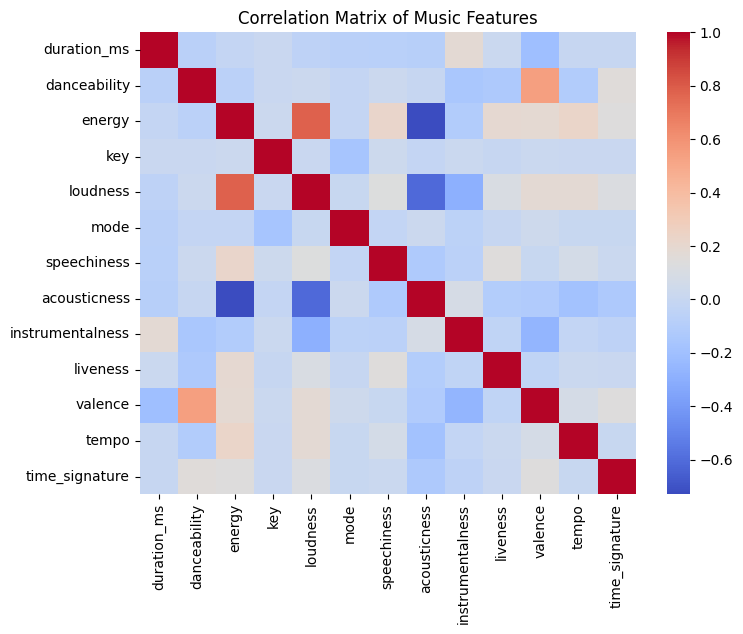

In [45]:
selected_columns = ['duration_ms', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 
                    'tempo', 'time_signature']

# Extract the relevant data from the DataFrame
music_data = df_songs[selected_columns]

# Calculate the correlation matrix
correlation_matrix = music_data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Music Features')
plt.show()

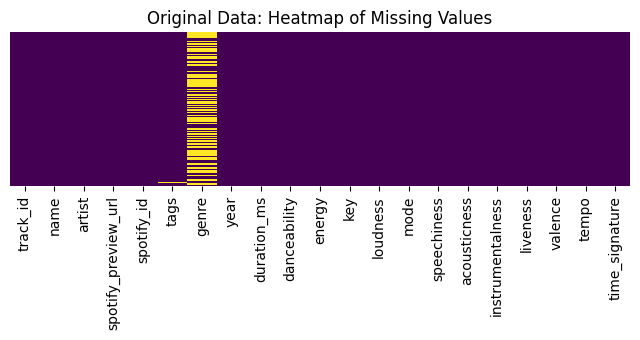

In [46]:
# Plot heatmap of missing values for the entire DataFrame
plt.figure(figsize=(8, 2))
sns.heatmap(
    df_songs_original.isnull(),  # Check for missing values across the entire DataFrame
    cmap='viridis',  # Use a colormap
    cbar=False,  # Hide the color bar
    yticklabels=False,  # Remove y-axis tick labels for readability
)
plt.title('Original Data: Heatmap of Missing Values')  # Optional: Add a title
plt.show()

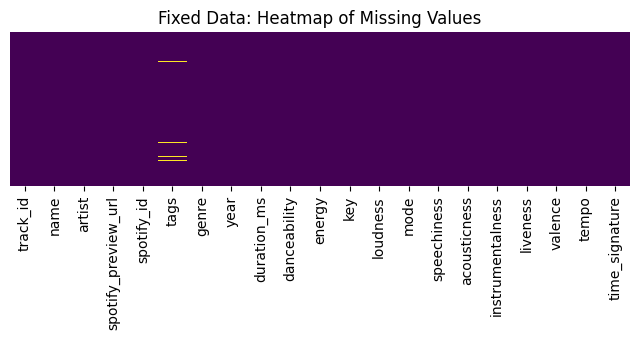

In [47]:
# Plot heatmap of missing values for the entire DataFrame
plt.figure(figsize=(8, 2))
sns.heatmap(
    df_songs.isnull(),  # Check for missing values across the entire DataFrame
    cmap='viridis',  # Use a colormap
    cbar=False,  # Hide the color bar
    yticklabels=False,  # Remove y-axis tick labels for readability
)
plt.title('Fixed Data: Heatmap of Missing Values')  # Optional: Add a title
plt.show()

I believe this explains why we could use the neural network to predict genre for those observations where the attribute is missing.

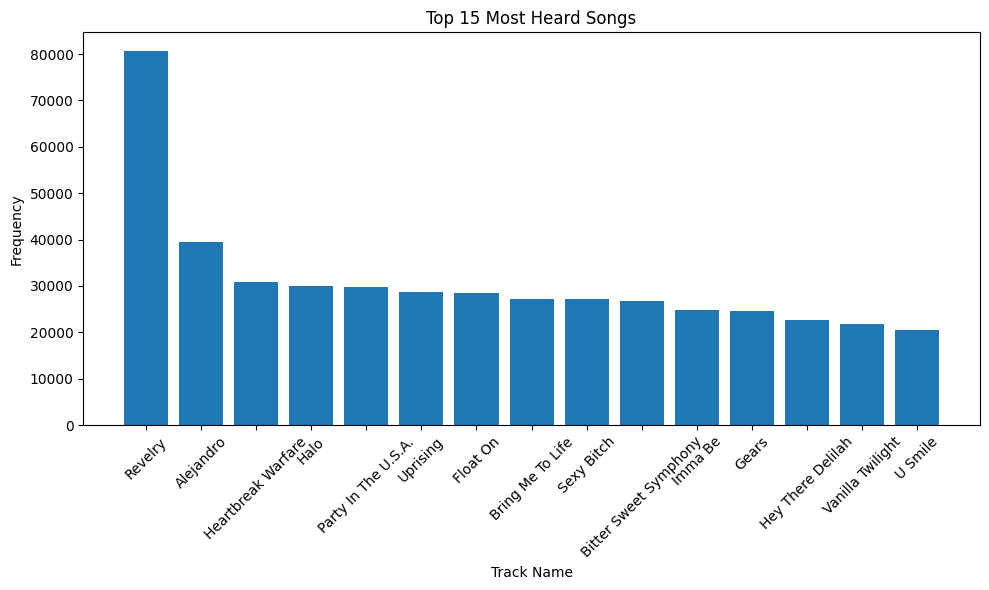

In [48]:
track_freq = df_users['track_id'].value_counts().reset_index()
track_freq.columns = ['track_id', 'frequency']

track_freq = track_freq.merge(df_songs, on='track_id')

top_15_tracks = track_freq.head(15)

plt.figure(figsize=(10, 6))
plt.bar(top_15_tracks['name'], top_15_tracks['frequency'])
plt.xlabel('Track Name')
plt.ylabel('Frequency')
plt.title('Top 15 Most Heard Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Load the clustered user data

In [ ]:
file_path_clusters = "Data/df_users.csv"
df_songs = pd.read_csv(file_path_clusters)

## Frequent Itemsets: Market basket

In [ ]:
# Calculate the total play count for each user
user_total_playcount = df_users.groupby('user_id')['playcount'].sum().reset_index()
user_total_playcount = user_total_playcount[user_total_playcount['playcount'] >= 50]

# Filter the original user data to include only users with at least 50 total plays
df_users_filtered = df_users[df_users['user_id'].isin(user_total_playcount['user_id'])]

# Process each cluster to generate individual DataFrames
cluster_dataframes = {}  # Dictionary to hold the dataframes for each cluster

for cluster_id in sorted(df_users_filtered['most_played_cluster'].unique()[:15]):  # Ensure max 15 clusters
    # Filter the data for the current cluster
    cluster_data = df_users_filtered[df_users_filtered['most_played_cluster'] == cluster_id]

    # Sort songs for each user by play count and select the 100 most played songs
    def get_top_songs(user_data):
        return user_data.nlargest(100, 'playcount')  # Adjust to desired number of top songs

    # Apply the top song selection for each user
    df_top_songs_cluster = cluster_data.groupby('user_id').apply(get_top_songs).reset_index(drop=True)

    # Create a basket for each user with their top songs
    df_basket_cluster = df_top_songs_cluster.groupby('user_id')['track_id'].apply(list).reset_index()
    df_basket_cluster.rename(columns={'track_id': 'basket'}, inplace=True)

    # Assign the DataFrame to a variable dynamically
    cluster_dataframes[f"df_basket_{cluster_id}"] = df_basket_cluster

    # Optionally, save to a named variable
    globals()[f"df_basket_{cluster_id}"] = df_basket_cluster

# We have 15 separate DataFrames stored as `df_basket_1`, `df_basket_2`, ..., `df_basket_10`

/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_16585/2292612857.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top_songs_cluster = cluster_data.groupby('user_id').apply(get_top_songs).reset_index(drop=True)
/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_16585/2292612857.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top_songs_cluster = cluster_data.groupby('user_id'

In [51]:
# Function to filter songs occurring in more than 10 baskets
def filter_songs(df_basket, min_basket_count=10):
    """
    Filters out songs from the baskets that occur in fewer than `min_basket_count` baskets.
    
    Parameters:
    - df_basket (pd.DataFrame): DataFrame with columns `user_id` and `basket`.
    - min_basket_count (int): Minimum number of baskets a song must appear in to be retained.

    Returns:
    - pd.DataFrame: Filtered DataFrame with updated baskets.
    """
    # Flatten all baskets into a single list to count song occurrences
    all_songs = [song for basket in df_basket['basket'] for song in basket]
    song_counts = Counter(all_songs)

    # Identify songs that occur in more than `min_basket_count` baskets
    frequent_songs = {song for song, count in song_counts.items() if count > min_basket_count}

    # Filter each user's basket to retain only frequent songs
    df_basket['basket'] = df_basket['basket'].apply(lambda basket: [song for song in basket if song in frequent_songs])

    # Remove rows with empty baskets
    df_basket = df_basket[df_basket['basket'].map(len) > 0].reset_index(drop=True)

    return df_basket

# Apply the function to each df_basket_# DataFrame
for cluster_id in cluster_dataframes.keys():
    cluster_dataframes[cluster_id] = filter_songs(cluster_dataframes[cluster_id])

    # Optionally, save back to dynamically created variables
    globals()[cluster_id] = cluster_dataframes[cluster_id]

### Association Rules

In [52]:
df_basket_2

,user_id,basket
0,0007be5e1168b8e4c7de1f9639eeaa1bbff44b94,"[TROMKCG128F9320C09, TRXHLUP128F9320B70, TRLUO..."
1,0015de25f44c66b36551716f1658e295ea09cfe0,"[TRRABPE128F42AA877, TRRZEOQ128F930C163, TRDDR..."
2,00174b4333940a6d59d56d68b6ce8181bd599ad6,"[TRBYSLP128F147CC94, TRWYIGP128F1454835, TRESW..."
3,001f10ed7e87879f68752300303642924b9e2ce2,"[TRLNLYC128F422B8D2, TRTAMNT128E07926F7, TRKMW..."
4,0025bfe6248070545d23721083acd3f60451da4f,"[TRVUHMK128F93096E7, TRKQTTP128EF34337D, TRSFL..."
...,...,...
6693,ffe2ec5b72cddb8537ad7f0ac191624f8ae2c8dc,"[TRTVSKV128F92EF7D0, TRDMMGE128F425D05E, TRILQ..."
6694,fff72469b03114d07d3f5a364ec7b5787565e908,"[TRCKWGF12903CD2DCD, TRRKXNQ128F9339002, TRRRY..."
6695,fff9bd021bf6e07936883b9bb045207fcf372a2c,"[TRBCLDH128F4293B4F, TRTTBVS128F421CD2E, TRFUO..."
6696,fffc0df75a48d823ad5abfaf2a1ee61eb1e3302c,"[TRKZCWR128E0785D71, TRKPWGR128E078EE06, TRJYS..."


In [ ]:
# Function to calculate support for itemsets
def calculate_support(data, itemsets):
    itemset_counts = defaultdict(int)
    for basket in data['basket']:
        for itemset in itemsets:
            if set(itemset).issubset(set(basket)):
                itemset_counts[itemset] += 1
    total_baskets = len(data)
    support = {itemset: count / total_baskets for itemset, count in itemset_counts.items()}
    return support

# Apriori Algorithm for Size 2 and 3
def apriori_pairs_and_triplets(data, min_support):
    frequent_itemsets = {}

    # Start with single items
    items = set(item for basket in data['basket'] for item in basket)
    single_itemsets = [(item,) for item in items]
    
    # Calculate support for single items
    support = calculate_support(data, single_itemsets)
    frequent_singles = [itemset for itemset, sup in support.items() if sup >= min_support]
    frequent_itemsets.update({itemset: support[itemset] for itemset in frequent_singles})
    
    print(f"Frequent Single Items: {frequent_singles}")
    
    # Generate pairs (size 2)
    pairs = list(combinations(set(item for itemset in frequent_singles for item in itemset), 2))
    pair_support = calculate_support(data, pairs)
    frequent_pairs = [itemset for itemset, sup in pair_support.items() if sup >= min_support]
    frequent_itemsets.update({itemset: pair_support[itemset] for itemset in frequent_pairs})
    
    print(f"Frequent Pairs: {frequent_pairs}")
    
    # Generate triplets (size 3)
    triplets = list(combinations(set(item for itemset in frequent_pairs for item in itemset), 3))
    triplet_support = calculate_support(data, triplets)
    frequent_triplets = [itemset for itemset, sup in triplet_support.items() if sup >= min_support]
    frequent_itemsets.update({itemset: triplet_support[itemset] for itemset in frequent_triplets})
    
    print(f"Frequent Triplets: {frequent_triplets}")
    
    return frequent_itemsets

In [54]:
# Step 3: Run Apriori Algorithm
data = df_basket_2
min_support = 0.02
frequent_itemsets = apriori_pairs_and_triplets(data, min_support)

# Print final results
print("\nFrequent Itemsets (Pairs and Triplets):")
for itemset, support in frequent_itemsets.items():
    print(f"{itemset}: {support:.2f}")

Frequent Single Items: [('TRPBCPV128F9302770',), ('TRXNVAQ128F93176BA',), ('TRXHLUP128F9320B70',), ('TRXXXDE12903CAE130',), ('TRQFICK128F92F5190',), ('TRJNGBW128F930276C',), ('TRGFQXC128F92F3C37',), ('TRGNTLG12903CF25D9',), ('TRCFRTP128F930276F',), ('TRFPEPB128F92EBCB8',), ('TROMKCG128F9320C09',), ('TRHCIJJ128F9305C8A',), ('TRSIKBL128F427F430',), ('TRVLXMQ128F9339980',), ('TROTJAW128F1466DCE',), ('TRRNZBN128F147CC7A',), ('TRRMNLW128F92D92B0',), ('TRUQERG128F147CBEA',), ('TRWKOEO128F147CC66',), ('TRJRIHX128F147CBC5',), ('TRPQPVO128F1460295',), ('TRWSXPD128F4259F3B',), ('TRBYSLP128F147CC94',), ('TRUNRBL128F92D92AC',), ('TRDGUAJ128F92D541D',), ('TRFMXJI128F930738B',), ('TRFLVKB128F147CC69',), ('TRZFXSA128F93073BE',), ('TREAYDQ128F147CC6C',), ('TRHOEPA128F4259F3F',), ('TRBKSWQ128F4259F3C',), ('TRGZAEU128E078393F',), ('TRUPDNU128F147CBE9',), ('TRBIZJO128F4259F57',), ('TRNRTQT128F4259F55',), ('TRUIIPM128F147CBD2',), ('TRYDIVP12903CAF5A7',), ('TRTAMNT128E07926F7',), ('TRUNYCG128F423A553',), (

In [55]:
triplets = {itemset: support for itemset, support in frequent_itemsets.items() if len(itemset) == 3}
duplets = {itemset: support for itemset, support in frequent_itemsets.items() if len(itemset) == 2}

In [56]:
# Create a mapping from track_id to name
id_to_name = df_songs.set_index('track_id')['name'].to_dict()

# Convert triplets' track_ids to names
triplets_with_names = {
    tuple(id_to_name[item] for item in triplet): support
    for triplet, support in triplets.items()
}

# Print triplets with names
print("Frequent Triplets with Names:")
for itemset, support in triplets_with_names.items():
    print(f"{itemset}: {support:.2f}")

Frequent Triplets with Names:
('Until It Sleeps', 'Ride the Lightning', 'Welcome Home (Sanitarium)'): 0.02
("Tears Don't Fall", 'Waking the Demon', 'Scream Aim Fire'): 0.02
('The Call of Ktulu', 'Ride the Lightning', 'Welcome Home (Sanitarium)'): 0.02


In [ ]:
# Convert duplets' track_ids to names
duplets_with_names = {
    tuple(id_to_name[item] for item in duplet): support
    for duplet, support in duplets.items()
}

# Filter out pairs including 'Revelry'
filtered_dublets = {
    pair: support for pair, support in duplets_with_names.items() if 'Revelry' not in pair
}

# Print filtered pairs
print("Filtered Dublets (excluding 'Revelry'):")
for pair, support in filtered_dublets.items():
    print(f"{pair}: {support:.2f}")

Filtered Dublets (excluding 'Revelry'):
('5.45', 'Servant in Heaven - King in Hell'): 0.03
('Meet the Monster', 'My Own Hell'): 0.03
('Rosenrot', 'Feuer Frei'): 0.02
('The Thing That Should Not Be', 'Until It Sleeps'): 0.02
('The Thing That Should Not Be', 'Welcome Home (Sanitarium)'): 0.03
('Broken, Beat & Scarred', 'The Unforgiven III'): 0.02
('Am I Evil?', 'Welcome Home (Sanitarium)'): 0.02
('Links 2 3 4', 'Feuer Frei'): 0.02
('The God That Failed', 'The Unforgiven III'): 0.02
('The God That Failed', 'Until It Sleeps'): 0.02
('The God That Failed', 'Welcome Home (Sanitarium)'): 0.02
('The Unforgiven III', 'Until It Sleeps'): 0.02
('The Unforgiven III', 'Welcome Home (Sanitarium)'): 0.03
('Until It Sleeps', 'Welcome Home (Sanitarium)'): 0.03
('The Call of Ktulu', 'Ride the Lightning'): 0.03
('Broken, Beat & Scarred', 'Ride the Lightning'): 0.02
('Fade to Black', 'Ride the Lightning'): 0.03
('Ride the Lightning', 'The God That Failed'): 0.03
('Ride the Lightning', 'The Unforgiven III'

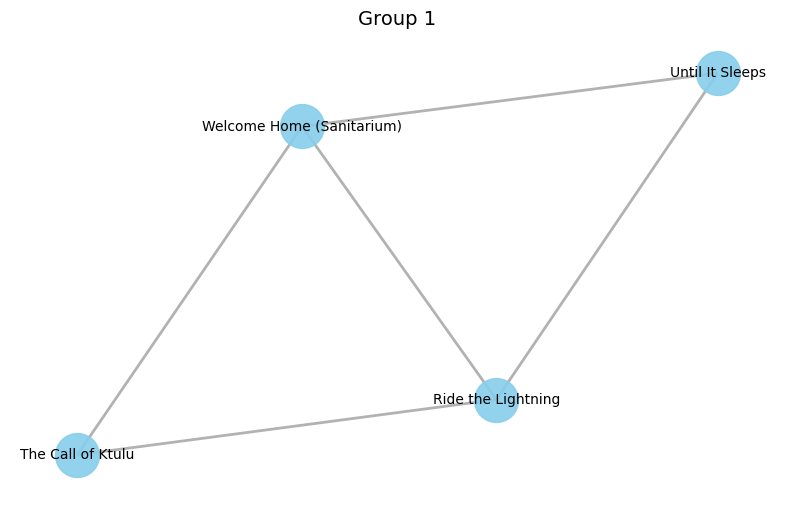

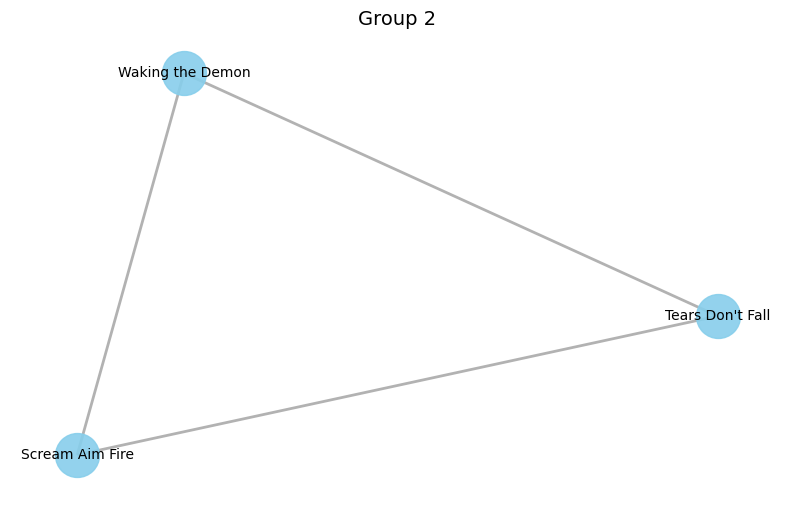

In [58]:
# Create the full graph
G = nx.Graph()

# Add edges for each triplet
for triplet in triplets_with_names:
    for pair in combinations(triplet, 2):
        G.add_edge(pair[0], pair[1])

# Identify connected components (clusters)
groups = [G.subgraph(c).copy() for c in nx.connected_components(G)]

# Plot each cluster
for i, group in enumerate(groups):
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(group, seed=42)  # Use spring layout for neat arrangement
    nx.draw_networkx_nodes(group, pos, node_size=1000, node_color='skyblue', alpha=0.9)
    nx.draw_networkx_edges(group, pos, width=2, edge_color='gray', alpha=0.6)
    nx.draw_networkx_labels(group, pos, font_size=10, font_color='black')
    plt.title(f"Group {i + 1}", fontsize=14)
    plt.axis('off')  # Turn off axes
    plt.show()

/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_16585/3333300076.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.031501940877873995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.loc[song1, song2] = support
/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_16585/3333300076.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.031501940877873995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.loc[song2, song1] = support  # Symmetric pairs
/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_16585/3333300076.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.025380710659898477' has dtype incompatible

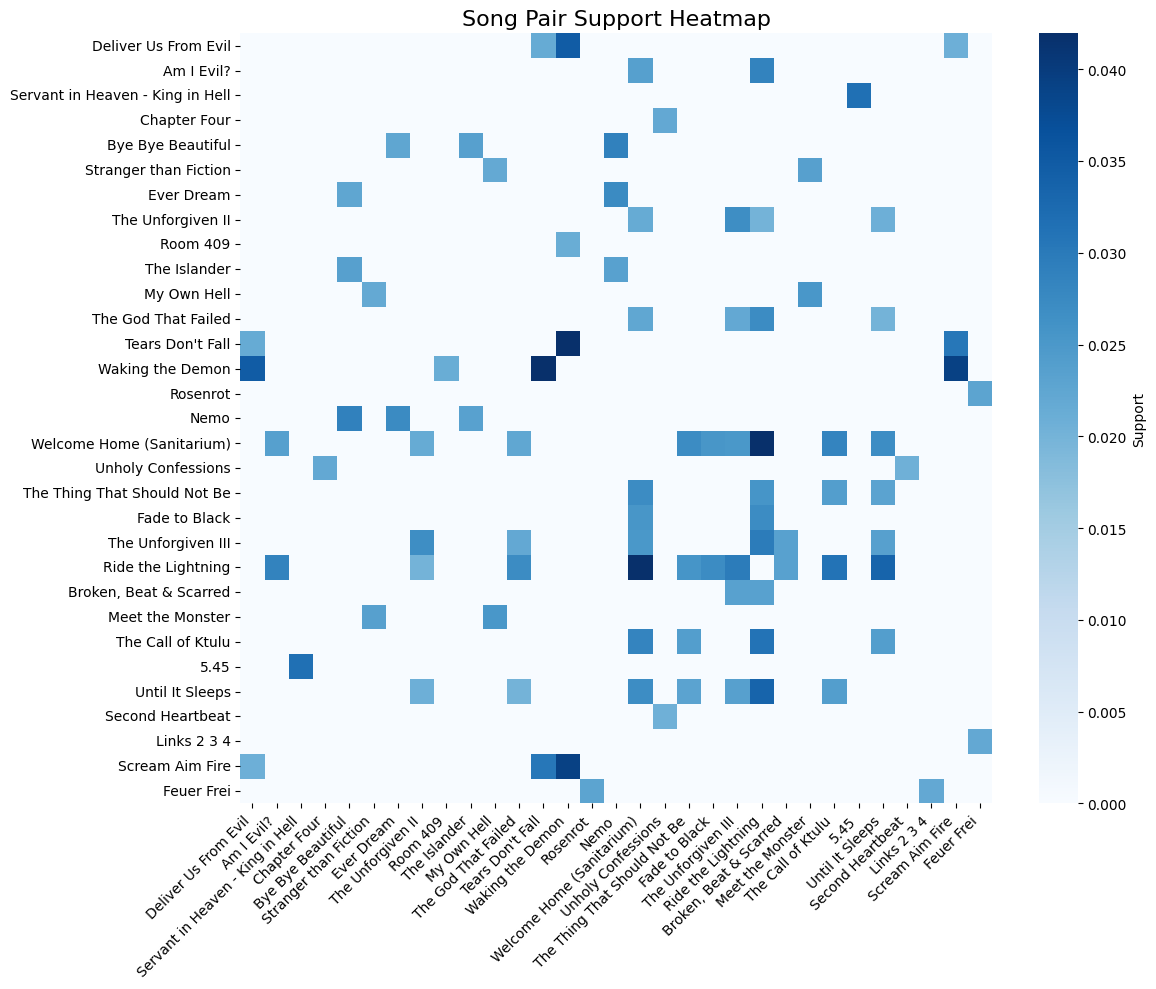

In [59]:
# Prepare data for heatmap
songs = list(set([item for pair in filtered_dublets.keys() for item in pair]))
heatmap_data = pd.DataFrame(0, index=songs, columns=songs)

for (song1, song2), support in filtered_dublets.items():
    heatmap_data.loc[song1, song2] = support
    heatmap_data.loc[song2, song1] = support  # Symmetric pairs

# Plot heatmap without annotations
plt.figure(figsize=(12, 10))  # Increase figure size
sns.heatmap(
    heatmap_data,
    annot=False,  # Remove annotations
    cmap="Blues",  # Use a blue colormap
    cbar_kws={'label': 'Support'}  # Add color bar label
)
plt.title('Song Pair Support Heatmap', fontsize=16)  # Increase title font size
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
plt.yticks(fontsize=10)  # Adjust y-axis label font size
plt.tight_layout()  # Adjust layout for better readability
plt.show()